# URT [Chapter 1](http://underactuated.csail.mit.edu/underactuated.html?chapter=1) Notes

Wayne H Nixalo - 2018/2/14 00:53

---

### Example 1.1 Robot Manipulators

The equations of motion for the double pendulum system are simple to derive (see [Appendix](http://underactuated.csail.mit.edu/underactuated.html?chapter=multibody)) and take the form of standard "manipulator equations":

$$M(q)\ddot{q}+C(q,\dot{q})\dot{q} = \tau_g(q)+Bu$$

The inertial matrix $M(q)$ is always uniformly symmetric & positive definite and $\Rightarrow$ is invertible. Putting the equation into [Equation 1](http://underactuated.csail.mit.edu/underactuated.html?chapter=1#mjx-eqn-eqf1_plus_f2) form yields: 

$$\ddot{q}=M^{-1}(q)[\tau_g(q)+Bu-C(q,\dot{q}]\dot(q)$$

Because $\textbf{M}^{-1}(\textbf{q})$ is always full rank, the system described by the manipulator eqns is FA $\iff$ $\textbf{B}$ is full row rank. Here $\textbf{q}=[\theta_1,\theta_2]^T$ and $\textbf{u}=[\tau_1,\tau_2]^T$ (motor torques at joints), and $\textbf{B}=\textbf{I}_{2\times2}$

In [1]:
%matplotlib inline

# from underactuated/src/double_pendulum/simulator.ipynb
# Run this cell first to import some modules 
# we'll need to run the examples below.
import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

from pydrake.multibody.rigid_body_tree import (
    RigidBodyTree, 
    FloatingBaseType
)
from pydrake.multibody.rigid_body_plant import (
    RigidBodyPlant
)
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import (
    Context,
    DiagramBuilder,
    LeafSystem,
    PortDataType,
    BasicVector
)
from pydrake.systems.primitives import (
    SignalLogger
)
from underactuated import ( FindResource, ManipulatorDynamics, PlanarRigidBodyVisualizer )

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from pydrake.all import (BasicVector, DiagramBuilder, FloatingBaseType,
                         RigidBodyPlant, RigidBodyTree, Simulator)
from underactuated import (FindResource, PlanarRigidBodyVisualizer)

# Load the double pendulum from Universal Robot Description Format
tree = RigidBodyTree(FindResource("double_pendulum/double_pendulum.urdf"),
                     FloatingBaseType.kFixed)

# Set up a block diagram with the robot (dynamics) and a visualization block.
builder = DiagramBuilder()
robot = builder.AddSystem(RigidBodyPlant(tree))
builder.ExportInput(robot.get_input_port(0))
# visualizer = builder.AddSystem(PlanarRigidBodyVisualizer(tree,
#                                                          xlim=[-2.8, 2.8],
#                                                          ylim=[-2.8, 2.8]))

# from underactuated/src/double_pendulum/simulator.ipynb:
# The logger needs to be told to expect a 4-element input
# (the 4-element double pendulum state, in this case).
logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(robot.get_output_port(0), logger.get_input_port(0))

# builder.Connect(robot.get_output_port(0), visualizer.get_input_port(0))
diagram = builder.Build()

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
simulator.set_target_realtime_rate(1.0)
simulator.set_publish_every_time_step(False)

# Set the initial conditions
context = simulator.get_mutable_context()
context.FixInputPort(0, BasicVector([0., 0.]))  # Zero input torques
state = context.get_mutable_continuous_state_vector()
# state.SetFromVector((1., 1., 0., 0.))  # (theta1, theta2, theta1dot, theta2dot)
state.SetFromVector((2.,0.5,0.2,0.0)) # more interesting

# Simulate for 10 seconds
simulator.StepTo(10)

# Visualize the result as a video. (from underactuated/src/double_pendulum/simulator.ipynb)
vis = PlanarRigidBodyVisualizer(tree, xlim=[-3.4,3.4], ylim=[-3.4,3.4], use_random_colors=True)
ani = vis.animate(logger, 60, repeat=True)
plt.close(vis.fig)
HTML(ani.to_html5_video())

/usr/lib/python2.7/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Spawning PlanarRigidBodyVisualizer for tree with 2 actuators


We can also use [Drake](http://drake.mit.edu/) to evaluate manipulator eqns:

In [10]:
from pydrake.all import (FloatingBaseType, RigidBodyTree)
from underactuated import (FindResource, ManipulatorDynamics)

tree = RigidBodyTree(FindResource("double_pendulum/double_pendulum.urdf"),
                     FloatingBaseType.kFixed)

q = (1., 1.)
v = (0.1, 0.1)
(M, Cv, tauG, B) = ManipulatorDynamics(tree, q, v)
print("M = " + str(M))
print("Cv = " + str(Cv))
print("tauG = " + str(tauG))
print("B = " + str(B))

M = [[ 4.08060461  1.54030231]
 [ 1.54030231  1.        ]]
Cv = [-0.01524413  0.01841471]
tauG = [-25.42986848  -8.92020776]
B = [[ 1.  0.]
 [ 0.  1.]]


**NOTE**: hmm, looks like this stuff isn't fully implemented yet. I'll try it again later.

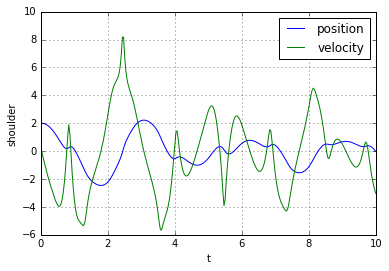

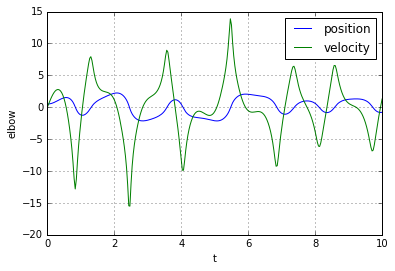

In [9]:
# from underactuated/src/double_pendulum/simulator.ipynb:
# Run this cell after running a simulation to plot traces 
# of the pendulum state across time.
fields = ["shoulder", "elbow"]
for i in xrange(2):
    # plt.subplot(3, 1, i+1)
    plt.plot(logger.sample_times(), logger.data()[(i, i+2), :].transpose())
    plt.legend(["position", "velocity"])
    plt.xlabel('t')
    plt.ylabel(fields[i])
    plt.grid(True)
    plt.show()